In [19]:
"""
lg_reviews_rag_pipeline.py

Context-based Sentiment Analysis for HR & Business Decision Making using LLM + RAG
(Aligned to your LJMU research proposal: preprocessing → LLM sentiment → RAG retrieval
→ consistency (genuine vs inconsistent) → Power BI export).  :contentReference[oaicite:1]{index=1}

Runs fully offline on Hugging Face models (downloads once on first run).
"""

'\nlg_reviews_rag_pipeline.py\n\nContext-based Sentiment Analysis for HR & Business Decision Making using LLM + RAG\n(Aligned to your LJMU research proposal: preprocessing → LLM sentiment → RAG retrieval\n→ consistency (genuine vs inconsistent) → Power BI export).  :contentReference[oaicite:1]{index=1}\n\nRuns fully offline on Hugging Face models (downloads once on first run).\n'

In [20]:
# =========================
# 0) IMPORTS & CONFIG
# =========================
import os, re, json, random
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm

# Text cleaning
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import emoji

# HF / ML
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer
import faiss
from keybert import KeyBERT

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)

# Dataset path: prefer environment variable; else default file name
DATA_PATH = r"employeeReviews.csv"

# Output directory for analytics & Power BI
OUTPUT_DIR = Path("outputs_8nov_RN")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Expected columns (we’ll auto-match actual names case/space-insensitively)
COL_RATING   = "overall_rating"
COL_LIKES    = "likes"
COL_DISLIKES = "dislikes"
COL_TITLE    = "title"       # optional
COL_DEPT     = "department"  # optional
COL_LOC      = "location"    # optional
COL_DATE     = "date"        # optional

# Hugging Face models (offline after first download)
SENTIMENT_MODEL  = "distilbert-base-uncased-finetuned-sst-2-english"
EMBED_MODEL      = "sentence-transformers/all-MiniLM-L6-v2"
LOCAL_SUMMARIZER = "t5-small"

# Retrieval hyperparams
TOP_K_RETRIEVE = 3

In [21]:
!pip install keybert

In [22]:
# =========================
# 1) UTILITIES
# =========================
def ensure_nltk():
    """Ensure NLTK stopwords are available (one-time download)."""
    try:
        nltk.data.find("corpora/stopwords")
    except LookupError:
        nltk.download("stopwords")

def match_col(target: str, cols) -> str:
    """
    Return the actual column name from df.columns that matches target
    ignoring case, spaces, and underscores.
    """
    norm_t = re.sub(r"[\s_]+", "", target.lower())
    for c in cols:
        if re.sub(r"[\s_]+", "", c.lower()) == norm_t:
            return c
    # If not found, return the original target (will error if missing)
    return target

def normalize_rating(r: object) -> float:
    """Normalize rating to [1,5] float; NaN if unparsable."""
    try:
        r = float(r)
    except Exception:
        return np.nan
    return max(1.0, min(5.0, r))

def clean_text(x: object) -> str:
    """
    Data Preprocessing (Cleaning):
    - Safe string conversion
    - Remove HTML, emojis, URLs
    - Lowercase
    - Remove special symbols (keep basic punctuation)
    - Normalize whitespace

    NOTE: We do NOT remove stopwords here to preserve sentiment cues.
    """
    if pd.isna(x):
        return ""
    x = str(x)
    x = BeautifulSoup(x, "html.parser").get_text(" ")
    x = emoji.replace_emoji(x, replace="")
    x = x.lower()
    x = re.sub(r"http\S+|www\.\S+", " ", x)
    x = re.sub(r"[^a-z0-9.,;:!?()'\"/\-\s]", " ", x)   # keep basic punctuation
    x = re.sub(r"\s+", " ", x).strip()
    return x

def to_tri_label(pos_prob: float, neg_prob: float, band: float = 0.15):
    """
    Convert binary POS/NEG probabilities into tri-label with a neutral band.
    If |pos-0.5| <= band, return NEUTRAL; else POSITIVE/NEGATIVE.
    """
    if abs(pos_prob - 0.5) <= band:
        return "NEUTRAL", 0.0
    return ("POSITIVE", 1.0) if pos_prob > neg_prob else ("NEGATIVE", -1.0)

def rating_to_label(r: float) -> int:
    """
    Map numeric overall rating to {-1,0,+1} buckets aligned to proposal:
      <=2 → -1 (NEG), 3 → 0 (NEU), >=4 → +1 (POS)
    """
    if pd.isna(r):
        return 0
    if r >= 4.0: return 1
    if r <= 2.0: return -1
    return 0

def combine_like_dislike(like_score: float, dislike_score: float) -> float:
    """
    Combine sentiment of Likes (L) and Dislikes (D) into a single score in [-1,1].
    - L contributes as-is (positive -> +)
    - Dislikes: negative sentiment is expected; invert sign => (-dislike_score)
    Then average & clip to [-1,1].
    """
    raw = like_score + (-dislike_score)
    return float(np.clip(raw/2.0, -1.0, 1.0))

def consistency_label(text_label: str, rating_bucket: int) -> str:
    """
    Produce final consistency class:
      - If text or rating is neutral/uncertain → AMBIGUOUS
      - If directions match (+/+ or -/-) → GENUINE
      - Else → INCONSISTENT
    """
    ts = 1 if text_label == "POSITIVE" else (-1 if text_label == "NEGATIVE" else 0)
    if ts == 0 or rating_bucket == 0:
        return "AMBIGUOUS"
    if (ts == 1 and rating_bucket == 1) or (ts == -1 and rating_bucket == -1):
        return "GENUINE"
    return "INCONSISTENT"


In [23]:
# =========================
# 2) LOAD & PREPROCESS DATA
# =========================
def load_and_preprocess(data_path: str) -> pd.DataFrame:
    """
    Load CSV → harmonize column names → preprocess & clean text →
    remove duplicates → basic null handling.
    """
    print(f"[LOAD] Reading dataset from: {data_path}")
    import csv as _csv
    from pandas.errors import ParserError

    try:
        df = pd.read_csv(data_path, engine="c", low_memory=False)
    except ParserError as e:
        print(f"[LOAD] C engine ParserError: {e}. Retrying with python engine (on_bad_lines='warn')...")
        try:
            df = pd.read_csv(
                data_path,
                engine="python",
                low_memory=False,
                on_bad_lines="warn",  
                encoding="utf-8",
                sep=",")
        except Exception as e2:
            print(f"[LOAD] Python engine also failed: {e2}. Trying fallback streaming reader to salvage rows...")
        
            safe_lines = []
            with open(data_path, "rb") as fh:
                for raw in fh:
                    # remove NUL bytes which sometimes cause C parser buffer issues
                    safe = raw.replace(b"\x00", b"")
                    safe_lines.append(safe.decode("utf-8", errors="replace"))
            from io import StringIO
            pseudo = StringIO("".join(safe_lines))
            df = pd.read_csv(pseudo, engine="python", on_bad_lines="warn")
    except Exception as e:
        # If any other exception occurs (e.g., FileNotFoundError), re-raise with context
        raise
  
    exp = [COL_RATING, COL_LIKES, COL_DISLIKES, COL_TITLE, COL_DEPT, COL_LOC, COL_DATE]
    mapping = {}
    for col in exp:
        if col is None: continue
        real = match_col(col, df.columns)
        mapping[col] = real

    # Validate required columns
    for req in [COL_RATING, COL_LIKES, COL_DISLIKES]:
        real = mapping[req]
        if real not in df.columns:
            raise ValueError(f"Missing required column: {req}. Present: {df.columns.tolist()}")

    # --- Keep only necessary columns + optional metadata if present ---
    keep_cols = [mapping[COL_RATING], mapping[COL_LIKES], mapping[COL_DISLIKES]]
    for opt in [COL_TITLE, COL_DEPT, COL_LOC, COL_DATE]:
        if opt and mapping.get(opt) in df.columns: keep_cols.append(mapping[opt])
    df = df[keep_cols].copy()

    # --- Rename columns to canonical names for downstream code ---
    ren = {
        mapping[COL_RATING]: "overall_rating",
        mapping[COL_LIKES]: "likes",
        mapping[COL_DISLIKES]: "dislikes",
    }
    if mapping.get(COL_TITLE) in df.columns: ren[mapping[COL_TITLE]] = "title"
    if mapping.get(COL_DEPT) in df.columns:  ren[mapping[COL_DEPT]]  = "department"
    if mapping.get(COL_LOC) in df.columns:   ren[mapping[COL_LOC]]   = "location"
    if mapping.get(COL_DATE) in df.columns:  ren[mapping[COL_DATE]]  = "date"
    df.rename(columns=ren, inplace=True)

    # --- Deduplicate (exact duplicates across selected columns) ---
    before = len(df)
    df.drop_duplicates(inplace=True)
    print(f"[CLEAN] Duplicates removed: {before - len(df)}")

    # --- Null handling (critical fields) ---
    # If both Likes & Dislikes missing/empty, drop the row (no text to analyze).
    df["likes"] = df["likes"].fillna("").astype(str)
    df["dislikes"] = df["dislikes"].fillna("").astype(str)
    mask_no_text = (df["likes"].str.strip() == "") & (df["dislikes"].str.strip() == "")
    dropped = int(mask_no_text.sum())
    df = df.loc[~mask_no_text].copy()
    print(f"[CLEAN] Rows dropped (no text): {dropped}")

    # --- Clean text (remove HTML, emojis, URLs, special symbols) ---
    ensure_nltk()
    df["likes_clean"]    = df["likes"].map(clean_text)
    df["dislikes_clean"] = df["dislikes"].map(clean_text)

    # --- Normalize numeric rating, build combined text field ---
    df["rating_norm"]   = df["overall_rating"].map(normalize_rating)
    df["text_combined"] = (df["likes_clean"].str.strip() + " " + df["dislikes_clean"].str.strip()).str.strip()

    # --- (Optional) filter extremely short texts after cleaning ---
    # Remove rows with fewer than 3 tokens to reduce noise
    df["tok_count"] = df["text_combined"].str.split().map(lambda x: len(x) if isinstance(x, list) else 0)
    short = (df["tok_count"] < 3)
    print(f"[CLEAN] Very-short reviews removed: {int(short.sum())}")
    df = df.loc[~short].drop(columns=["tok_count"]).reset_index(drop=True)

    return df


In [24]:
# =========================
# 3) SENTIMENT (HF LLM)
# =========================
def run_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Run DistilBERT (HF) for Likes/Dislikes separately.
    Convert to tri-label with a neutral band, then combine into a single text score/label.
    """
    print("[SENTIMENT] Loading sentiment model (first run may download HF weights)...")
    sent_clf = pipeline("sentiment-analysis", model=SENTIMENT_MODEL)

    def predict_sent(text: str):
        if not text or not text.strip():
            return ("NEUTRAL", 0.0)
        res = sent_clf(text[:512])[0]  # truncate to safe length
        lab = res["label"].upper(); p = float(res["score"])
        # Convert binary POS/NEG to tri-label
        return to_tri_label(p, 1.0 - p) if lab == "POSITIVE" else to_tri_label(1.0 - p, p)

    print("[SENTIMENT] Scoring Likes & Dislikes...")
    likes_pred    = df["likes_clean"].map(predict_sent)
    dislikes_pred = df["dislikes_clean"].map(predict_sent)

    df["like_sent_label"]     = [a for a, b in likes_pred]
    df["like_sent_score"]     = [b for a, b in likes_pred]
    df["dislike_sent_label"]  = [a for a, b in dislikes_pred]
    df["dislike_sent_score"]  = [b for a, b in dislikes_pred]

    # Combine to a single text sentiment score/label
    df["text_sent_score"] = [combine_like_dislike(ls, ds)
                             for ls, ds in zip(df["like_sent_score"], df["dislike_sent_score"])]
    df["text_sent_label"] = df["text_sent_score"].map(
        lambda v: "POSITIVE" if v > 0.15 else ("NEGATIVE" if v < -0.15 else "NEUTRAL")
    )

    # Map rating to {-1,0,+1} buckets
    df["rating_label"] = df["rating_norm"].map(rating_to_label)
    return df

In [25]:
def get_sentiment_score(text: str, classifier) -> float:
    """
    Runs a 5-star sentiment model (like 'nlptown') and maps its
    label to a continuous score from -1.0 to +1.0.
    """
    if not text or not text.strip():
        return 0.0  # Return neutral for empty text
    
    # Run the model
    res = classifier(text[:512])[0]
    print(res)
    label = res['label'].lower()

    # Create a mapping from star labels to a -1 to +1 score
    if "5 stars" in label:
        return 1.0
    elif "4 stars" in label:
        return 0.5
    elif "3 stars" in label:
        return 0.0  # This is the key: a native "NEUTRAL"
    elif "2 stars" in label:
        return -0.5
    elif "1 star" in label:
        return -1.0
    
    return 0.0 # Default fallback

def run_sentiment_v1(df: pd.DataFrame, neutral_threshold: float = 0.15) -> pd.DataFrame:
    """
    Combines Likes/Dislikes text first, then runs sentiment analysis once
    for a more context-aware score.
    
    Args:
        df: The input DataFrame.
        neutral_threshold: The score margin to classify as NEUTRAL.
                           Scores between [-threshold, +threshold] are neutral.
    """
    print("[SENTIMENT] Loading sentiment model (nlptown/bert-base-multilingual-uncased-sentiment)...")
    
    # --- THIS IS THE MODEL CHANGE ---
    SENTIMENT_MODEL = "nlptown/bert-base-multilingual-uncased-sentiment"
    sent_clf = pipeline("sentiment-analysis", model=SENTIMENT_MODEL)

    print("[SENTIMENT] Combining text and scoring...")
    
    # 1. Combine Text
    def combine_text(row):
        like_text = str(row['likes_clean']).strip()
        dislike_text = str(row['dislikes_clean']).strip()
        
        if like_text and dislike_text:
            # Use "Pros" and "Cons" as context words
            return f"Pros: {like_text}. Cons: {dislike_text}."
        elif like_text:
            return f"Pros: {like_text}."
        elif dislike_text:
            return f"Cons: {dislike_text}."
        else:
            return "" # Empty string

    df['full_comment'] = df.apply(combine_text, axis=1)
    
    # 2. Run Sentiment Once
    # This now calls the NEW get_sentiment_score function
    df['text_sent_score'] = df['full_comment'].map(
        lambda text: get_sentiment_score(text, sent_clf)
    )

    # 3. Use the Result
    # This now uses the threshold you pass in (or 0.15 default)
    print(f"[SENTIMENT] Applying neutral band with threshold: +/- {neutral_threshold}")
    df["text_sent_label"] = df["text_sent_score"].map(
        lambda v: "POSITIVE" if v > neutral_threshold else ("NEGATIVE" if v < -neutral_threshold else "NEUTRAL")
    )

    # Map rating to {-1,0,+1} buckets
    df["rating_label"] = df["rating_norm"].map(rating_to_label)
    return df


In [26]:
def get_sentiment_score(text: str, classifier) -> float:
    """
    Runs a 5-star sentiment model (like 'nlptown') and maps its
    label to a continuous score from -1.0 to +1.0.
    """
    if not text or not text.strip():
        # Return 999 as a "null" flag, NOT 0.0 (which is a valid "neutral" score)
        return 999 
    
    res = classifier(text[:512])[0]
    label = res['label'].lower()

    if "5 stars" in label:
        return 1.0
    elif "4 stars" in label:
        return 0.5
    elif "3 stars" in label:
        return 0.0
    elif "2 stars" in label:
        return -0.5
    elif "1 star" in label:
        return -1.0
    
    return 999 # Fallback for "null"

def combine_scores(like_score: float, dislike_score: float) -> float:
    """
    Intelligently combines the separate Like and Dislike scores.
    Uses 999 as a "null" flag.
    """
    # Check if scores are valid
    has_like = like_score != 999
    has_dislike = dislike_score != 999
    
    if has_like and has_dislike:
        # Both exist: Average them. This is the mixed review case.
        # e.g., (1.0 + -0.5) / 2 = 0.25
        return (like_score + dislike_score) / 2.0
    elif has_like:
        # Only "Like" text exists. Use its score directly.
        return like_score
    elif has_dislike:
        # Only "Dislike" text exists. Use its score directly.
        return dislike_score
    else:
        # No text at all. Return 0.0 (Neutral)
        return 0.0

def run_sentiment_v2(df: pd.DataFrame, neutral_threshold: float = 0.15) -> pd.DataFrame:
    """
    V3: Analyzes Likes/Dislikes separately using the 5-star model,
    then correctly combines them.
    """
    print("[SENTIMENT] Loading sentiment model (nlptown/bert-base-multilingual-uncased-sentiment)...")
    SENTIMENT_MODEL = "nlptown/bert-base-multilingual-uncased-sentiment"
    sent_clf = pipeline("sentiment-analysis", model=SENTIMENT_MODEL)

    print("[SENTIMENT] Scoring Likes & Dislikes separately...")
    
    # 1. Run Sentiment on each column
    # The new get_sentiment_score returns 999 for empty text
    df['like_sent_score_raw'] = df["likes_clean"].map(
        lambda text: get_sentiment_score(text, sent_clf)
    )
    df['dislike_sent_score_raw'] = df["dislikes_clean"].map(
        lambda text: get_sentiment_score(text, sent_clf)
    )

    # 2. Combine the scores
    print("[SENTIMENT] Combining scores...")
    df['text_sent_score'] = [
        combine_scores(ls, ds) 
        for ls, ds in zip(df['like_sent_score_raw'], df['dislike_sent_score_raw'])
    ]
    
    # 3. Apply the threshold
    # We can go back to using the optimization script now!
    print(f"[SENTIMENT] Applying neutral band with threshold: +/- {neutral_threshold}")
    df["text_sent_label"] = df["text_sent_score"].map(
        lambda v: "POSITIVE" if v > neutral_threshold else ("NEGATIVE" if v < -neutral_threshold else "NEUTRAL")
    )

    # Map rating to {-1,0,+1} buckets
    df["rating_label"] = df["rating_norm"].map(rating_to_label)
    
    # Optional: clean up intermediate columns
    df = df.drop(columns=['like_sent_score_raw', 'dislike_sent_score_raw'])
    
    return df

In [27]:
# =========================
# 4) RAG: EMBEDDINGS + FAISS
# =========================
def build_retriever(df: pd.DataFrame):
    """
    Encode each review's combined text using Sentence-BERT, index with FAISS (inner product).
    Returns (embedder, index, embeddings ndarray).
    """
    print("[RAG] Building sentence embeddings & FAISS index...")
    embedder = SentenceTransformer(EMBED_MODEL)
    corpus = df["text_combined"].fillna("").astype(str).tolist()
    embeddings = embedder.encode(corpus, normalize_embeddings=True, show_progress_bar=True)
    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings.astype("float32"))
    return embedder, index, embeddings

def retrieve_similar(embeddings: np.ndarray, index, idx: int, k: int = TOP_K_RETRIEVE):
    """
    Return top-k similar indices & scores for a given row idx (excluding itself).
    """
    vec = embeddings[idx].reshape(1, -1).astype("float32")
    scores, ids = index.search(vec, k+1)
    out = []
    for s, i in zip(scores[0], ids[0]):
        i = int(i)
        if i == idx: 
            continue
        out.append((i, float(s)))
    return out[:k]


In [28]:
# =========================
# 5) LOCAL SUMMARIES (T5)
# =========================
def load_summarizer():
    """Load a small local text-to-text summarizer (T5-small)."""
    print("[SUMMARIZER] Loading local T5 model...")
    tok = AutoTokenizer.from_pretrained(LOCAL_SUMMARIZER)
    mod = AutoModelForSeq2SeqLM.from_pretrained(LOCAL_SUMMARIZER)
    return pipeline("text2text-generation", model=mod, tokenizer=tok)

def make_context(df: pd.DataFrame, idx: int, nbrs: List[Tuple[int, float]]) -> str:
    """
    Compose a compact context string with [TARGET] + a few [SIMILAR] reviews.
    """
    parts = [f"[TARGET] {df.loc[idx, 'text_combined']}"]
    for j, sc in nbrs:
        parts.append(f"[SIMILAR {j} | score={sc:.3f}] {df.loc[j, 'text_combined']}")
    ctx = "\n".join(parts)
    # Keep short for T5-small
    return ctx[:1500]

def add_rag_summaries(df: pd.DataFrame, embeddings: np.ndarray, index, sample_n: int = 10) -> pd.DataFrame:
    """
    Generate short, local summaries for the first N rows (or fewer if dataset is smaller).
    Keeps compute modest for 8GB RAM laptops.
    """
    n = min(sample_n, len(df))
    if n == 0:
        df["rag_explanation"] = ""
        return df
    summarizer = load_summarizer()
    print(f"[SUMMARIZER] Generating summaries for {n} rows...")
    rag_texts = []
    for i in range(n):
        nbrs = retrieve_similar(embeddings, index, i, TOP_K_RETRIEVE)
        ctx = make_context(df, i, nbrs)
        out = summarizer("summarize: " + ctx, max_length=120, min_length=40, do_sample=False)[0]["generated_text"]
        rag_texts.append(out)
    df.loc[:n-1, "rag_explanation"] = rag_texts
    # Fill remaining rows with empty strings to keep column consistent
    if n < len(df):
        df.loc[n:, "rag_explanation"] = ""
    return df


In [29]:
# =========================
# 6) CONSISTENCY & THEMES
# =========================
def add_consistency_and_keywords(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add the final consistency label and extract top themes via KeyBERT.
    Save themes to outputs/keywords.json.
    """
    print("[CONSISTENCY] Labeling genuine vs inconsistent vs ambiguous...")
    df["consistency_label"] = df.apply(lambda r: consistency_label(r["text_sent_label"], r["rating_label"]), axis=1)

    print("[KEYBERT] Extracting positive/negative themes...")
    kw_model = KeyBERT(model=EMBED_MODEL)

    def top_keywords(texts: List[str], top_n: int = 12):
        joined = " ".join(texts)
        try:
            return kw_model.extract_keywords(joined, keyphrase_ngram_range=(1,2), stop_words="english", top_n=top_n)
        except Exception:
            return []

    neg_texts = df[(df["consistency_label"]=="GENUINE") & (df["text_sent_label"]=="NEGATIVE")]["text_combined"].dropna().tolist()
    pos_texts = df[(df["consistency_label"]=="GENUINE") & (df["text_sent_label"]=="POSITIVE")]["text_combined"].dropna().tolist()

    neg_kws = top_keywords(neg_texts, 15)
    pos_kws = top_keywords(pos_texts, 15)

    with open(OUTPUT_DIR / "keywords.json", "w", encoding="utf-8") as f:
        json.dump({"negative": neg_kws, "positive": pos_kws}, f, ensure_ascii=False, indent=2)

    return df

In [30]:
def run_chi_square(df):
    from scipy.stats import chi2_contingency
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    print("\n=== CHI-SQUARE TEST: Rating vs Text Sentiment ===")

    df_chi = df.dropna(subset=["rating_label", "text_sent_label"]).copy()

    # Contingency table
    cont_table = pd.crosstab(df_chi["rating_label"], df_chi["text_sent_label"])
    print("Contingency Table:")
    print(cont_table)

    # Chi-square
    chi2, p, dof, expected = chi2_contingency(cont_table)
    print("\nChi-Square Statistic:", round(chi2, 3))
    print("Degrees of Freedom:", dof)
    print("P-value:", round(p, 5))

    # Optional plot
    sns.heatmap(cont_table, annot=True, fmt="d", cmap="Blues")
    plt.title("Rating vs Text Sentiment (Contingency Table)")
    plt.xlabel("Predicted Sentiment (Text)")
    plt.ylabel("Rating-Based Sentiment")
    plt.show()

    return cont_table, chi2, p


In [31]:
# =========================
# 7) EXPORTS
# =========================
def export_for_powerbi(df: pd.DataFrame):
    """
    Export cleaned analytics to CSV/XLSX + keywords.json.
    Keep columns that are most useful for dashboarding and analysis.
    """
    export_cols = [
        "overall_rating", "rating_norm", "rating_label",
        "likes", "like_sent_label", "like_sent_score",
        "dislikes", "dislike_sent_label", "dislike_sent_score",
        "text_combined", "text_sent_label", "text_sent_score",
        "consistency_label", "rag_explanation"
    ]
    for opt in ["title", "department", "location", "date"]:
        if opt in df.columns:
            export_cols.append(opt)

    csv_path  = OUTPUT_DIR / "processed_reviews.csv"
    xlsx_path = OUTPUT_DIR / "processed_reviews.xlsx"
    df[export_cols].to_csv(csv_path, index=False)
    df[export_cols].to_excel(xlsx_path, index=False)
    print("[EXPORT] Saved:")
    print("  -", csv_path)
    print("  -", xlsx_path)
    print("  -", OUTPUT_DIR / "keywords.json")


In [32]:
!pip install kagglehub

In [33]:
def get_sentiment_label(text: str, classifier) -> float:
    """
    Runs a 5-star sentiment model (like 'nlptown') and maps its
    label to a continuous score from -1.0 to +1.0.
    """
    if not text or not text.strip():
        return 0.0  # Return neutral for empty text
    
    # Run the model
    res = classifier(text[:512])[0]
    # print(res)
    label = res['label']

    return label
  


In [34]:
def run_sentiment_like_dislike(df: pd.DataFrame, neutral_threshold: float = 0.15) -> pd.DataFrame:
    """
    V3: Analyzes Likes/Dislikes separately using the 5-star model,
    then correctly combines them.
    """
    print("[SENTIMENT] Loading sentiment model (siebert/sentiment-roberta-large-english)...")
    SENTIMENT_MODEL = "siebert/sentiment-roberta-large-english"
    sent_clf = pipeline("sentiment-analysis", model=SENTIMENT_MODEL)

    print("[SENTIMENT] Scoring Likes & Dislikes separately...")
    
    # 1. Run Sentiment on each column
    # The new get_sentiment_score returns 999 for empty text
    df['like_sent_score_raw'] = df["likes_clean"].map(
        lambda text: get_sentiment_label(text, sent_clf)
    )
    df['dislike_sent_score_raw'] = df["dislikes_clean"].map(
        lambda text: get_sentiment_label(text, sent_clf)
    )

    print(f"[SENTIMENT] Applying neutral band with threshold: +/- {0.5} on like sent")
    df["like_sent_score_lable"] = df["like_sent_score_raw"].map(
        lambda v: "true" if v == "POSITIVE" else "false"
    )

    print(f"[SENTIMENT] Applying neutral band with threshold: +/- {0.5} on dislike sent")
    df["dislike_sent_score_lable"] = df["dislike_sent_score_raw"].map(
        lambda v: "true" if v == "NEGATIVE" else "false"
    )
    

    
    # Optional: clean up intermediate columns
   
    
    return df

[LOAD] Reading dataset from: employeeReviews.csv
[LOAD] C engine ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
. Retrying with python engine (on_bad_lines='warn')...
[LOAD] Python engine also failed: The 'low_memory' option is not supported with the 'python' engine. Trying fallback streaming reader to salvage rows...
[CLEAN] Duplicates removed: 174
[CLEAN] Rows dropped (no text): 268


C:\Users\USER\AppData\Local\Temp\ipykernel_18244\210887135.py:36: ParserWarning: Skipping line 24: new-line character seen in unquoted field - do you need to open the file in universal-newline mode?

  df = pd.read_csv(pseudo, engine="python", on_bad_lines="warn")


[CLEAN] Very-short reviews removed: 155
[SENTIMENT] Loading sentiment model (siebert/sentiment-roberta-large-english)...


Device set to use cpu


[SENTIMENT] Scoring Likes & Dislikes separately...
[SENTIMENT] Applying neutral band with threshold: +/- 0.5 on like sent
[SENTIMENT] Applying neutral band with threshold: +/- 0.5 on dislike sent
      overall_rating                                              likes  \
0                2.0           Salary on time\nSystem and basic process   
1                5.0  LG Electronics India Pvt Ltd is one of the gre...   
2                5.0    product ARE GOOD AND SERVICES PROVIDED BY BRAND   
3                5.0  Salary on time , increment depends on manager ...   
4                4.0                     Good salary and bonus benefits   
...              ...                                                ...   
2254             NaN                        Ac service and installation   
2255             NaN                                    company culture   
2256             NaN                                                yes   
2257             NaN  responsible staff in lg electron

Device set to use cpu


[SENTIMENT] Scoring Likes & Dislikes...
[SENTIMENT] Loading sentiment model (nlptown/bert-base-multilingual-uncased-sentiment)...


Device set to use cpu


[SENTIMENT] Scoring Likes & Dislikes separately...
[SENTIMENT] Combining scores...
[SENTIMENT] Applying neutral band with threshold: +/- 0.15
[RAG] Building sentence embeddings & FAISS index...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

[SUMMARIZER] Loading local T5 model...


Device set to use cpu


[SUMMARIZER] Generating summaries for 10 rows...


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[CONSISTENCY] Labeling genuine vs inconsistent vs ambiguous...
[KEYBERT] Extracting positive/negative themes...
[EXPORT] Saved:
  - outputs_8nov_RN\processed_reviews.csv
  - outputs_8nov_RN\processed_reviews.xlsx
  - outputs_8nov_RN\keywords.json

=== CHI-SQUARE TEST: Rating vs Text Sentiment ===
Contingency Table:
text_sent_label  NEGATIVE  NEUTRAL  POSITIVE
rating_label                                
-1                    133       69        95
 0                    103       79       125
 1                    342      393       920

Chi-Square Statistic: 101.033
Degrees of Freedom: 4
P-value: 0.0


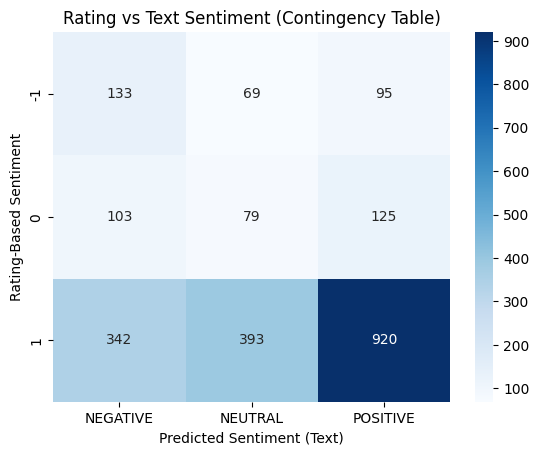

In [35]:
# =========================
# 8) MAIN
# =========================
def main():
    # 1) Load + Preprocess (nulls, duplicates, special symbols, short texts)
    df = load_and_preprocess(DATA_PATH)
    df = run_sentiment_like_dislike(df)
    print(df)
    like_counts = df["like_sent_score_lable"].value_counts()
    print(like_counts)

    like_counts = df["dislike_sent_score_lable"].value_counts()
    print(like_counts)
    

    # # 2) Sentiment (Likes & Dislikes → tri-label; combine → text_sent_label/score)
    df = run_sentiment(df)
    
    # df = run_sentiment_v1(df)
    df = run_sentiment_v2(df)
   
    # # # 3) RAG setup (Sentence-BERT + FAISS) and 4) Local T5 summaries on a sample
    embedder, index, embeddings = build_retriever(df)
    df = add_rag_summaries(df, embeddings, index, sample_n=10)  # adjust N as needed

    # # # 5) Consistency & Themes
    df = add_consistency_and_keywords(df)
    

    # # 6) Export to CSV/XLSX (Power BI) + keywords.json
    export_for_powerbi(df)
    
    # ✅ Chi-square test here
    run_chi_square(df)

if __name__ == "__main__":
    main()


In [36]:
import torch

In [37]:
import torch, sys
sys.modules['torch'] = torch

from transformers import pipeline
sentiment = pipeline("sentiment-analysis",
                     model="siebert/sentiment-roberta-large-english", device=-1)
print(sentiment("This not works now!"))

Device set to use cpu


[{'label': 'NEGATIVE', 'score': 0.999450147151947}]


In [38]:
!pip freeze

aiobotocore @ file:///C:/b/abs_1c1a_vjay2/croot/aiobotocore_1682537737724/work
aiofiles @ file:///C:/b/abs_9ex6mi6b56/croot/aiofiles_1683773603390/work
aiohttp @ file:///C:/b/abs_b78zt6vo64/croot/aiohttp_1694181126607/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///C:/b/abs_9djc_0pyi3/croot/aiosqlite_1683773915844/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///C:/b/abs_f4tsjyl9va/croot/anaconda-anon-usage_1695310457827/work
anaconda-catalogs @ file:///C:/b/abs_8btyy0o8s8/croot/anaconda-catalogs_1685727315626/work
anaconda-client @ file:///C:/b/abs_80wttmgui4/croot/anaconda-client_1694625288614/work
anaconda-cloud-auth @ file:///C:/b/abs_5cjpnu6wjb/croot/anaconda-cloud-auth_1694462130037/work
anaconda-navigator @ file:///C:/b/abs_ab00e0_u7e/croot/anaconda-navigator_1695238210954/work
anaconda-project @ file:///C:/c